In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# What kind of data/files we have there?
import os
for dirname, _, filenames in os.walk('/kaggle/input/denoising-dirty-documents'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/denoising-dirty-documents/train.zip
/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip
/kaggle/input/denoising-dirty-documents/train_cleaned.zip
/kaggle/input/denoising-dirty-documents/test.zip


In [5]:
# path to zipped & working directories
path_zip = '/kaggle/input/denoising-dirty-documents/'

# unzip files first to working directory
# We could use also unzipped data source, but why not to learn something new?
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall()  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall()  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()  

In [19]:
# store image names in list for later use
def images_name(file_dir):
    import os
    lst = []
    for dirname, _, filenames in os.walk(file_dir):
        for filename in filenames:
            lst.append(os.path.join(dirname, filename).split("/")[-1])
    return sorted(lst)

train_names = images_name("/kaggle/working/train")
train_cleaned_names = images_name("/kaggle/working/train_cleaned")
test_names = images_name("/kaggle/working/test")

In [7]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [8]:
# Reshape images and put them into list.
def images_paths(file_dir):
    import os
    lst = []
    for dirname, _, filenames in os.walk(file_dir):
        for filename in filenames:
            lst.append(os.path.join(dirname, filename))
    return sorted(lst)

train = [process_image(p) for p in images_paths("/kaggle/working/train")]
train_cleaned = [process_image(p) for p in images_paths("/kaggle/working/train_cleaned")]
test = [process_image(p) for p in images_paths("/kaggle/working/test")]


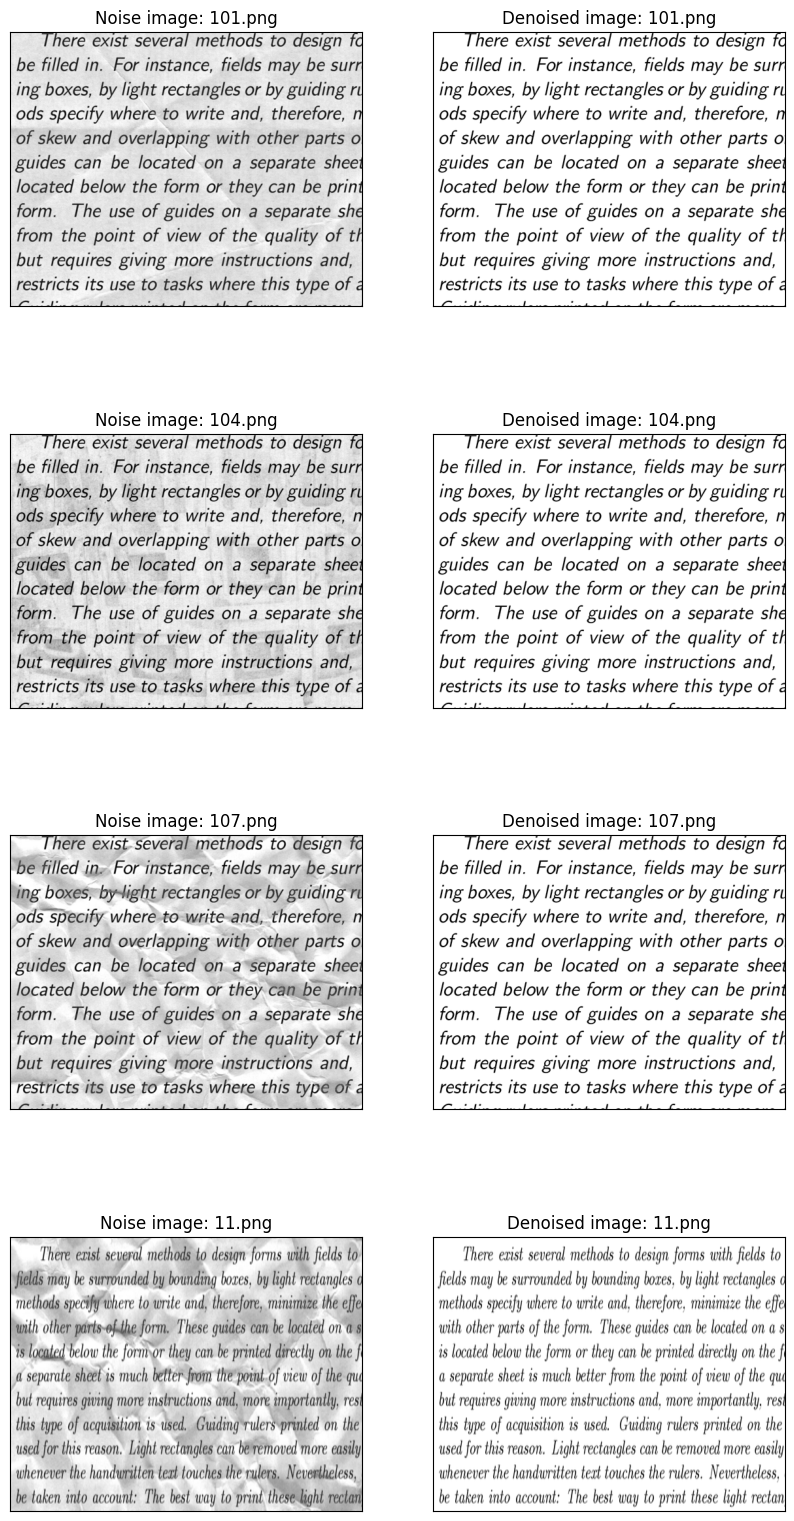

In [9]:
# Not too much to look there, but just quickly look on train images and their cleaned version. 
# This is what we put into model to learn how to clean noise from background.
plt.figure(figsize=(10,20))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_names[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_names[i]))

plt.show()

In [10]:
# Split data:
# In this step we convert lists to numpy arrays and split dataset 
# into train and validation in ration 85% train, 15% test.

# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [11]:
# create model 
def model():
    input_layer = Input(shape=(420, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=tf.metrics.RootMeanSquaredError())

    return model


model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

In [13]:
#Train model

# Verbose is going to be set to 0 to avoid filling output with hundreds of lines from training. 
# We will run 300 epochs having early stopping set to 20 (if val loss does not drop in 20 epochs, it will stop).
# Let's store history of model as well, so we can plot loss (rmse) and mae.

callback = EarlyStopping(monitor='loss', patience=5)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), 
                    epochs=30, batch_size=8, callbacks=[callback])

Epoch 1/30
16/16 [==============================] - 27s 1s/step - loss: 0.0877 - root_mean_squared_error: 0.2961 - val_loss: 0.1457 - val_root_mean_squared_error: 0.3817
Epoch 2/30
16/16 [==============================] - 11s 663ms/step - loss: 0.0367 - root_mean_squared_error: 0.1916 - val_loss: 0.0976 - val_root_mean_squared_error: 0.3125
Epoch 3/30
16/16 [==============================] - 11s 684ms/step - loss: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.0731 - val_root_mean_squared_error: 0.2704
Epoch 4/30
16/16 [==============================] - 11s 689ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 0.0664 - val_root_mean_squared_error: 0.2576
Epoch 5/30
16/16 [==============================] - 11s 692ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0655 - val_root_mean_squared_error: 0.2559
Epoch 6/30
16/16 [==============================] - 11s 681ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.0659 - v

In [15]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

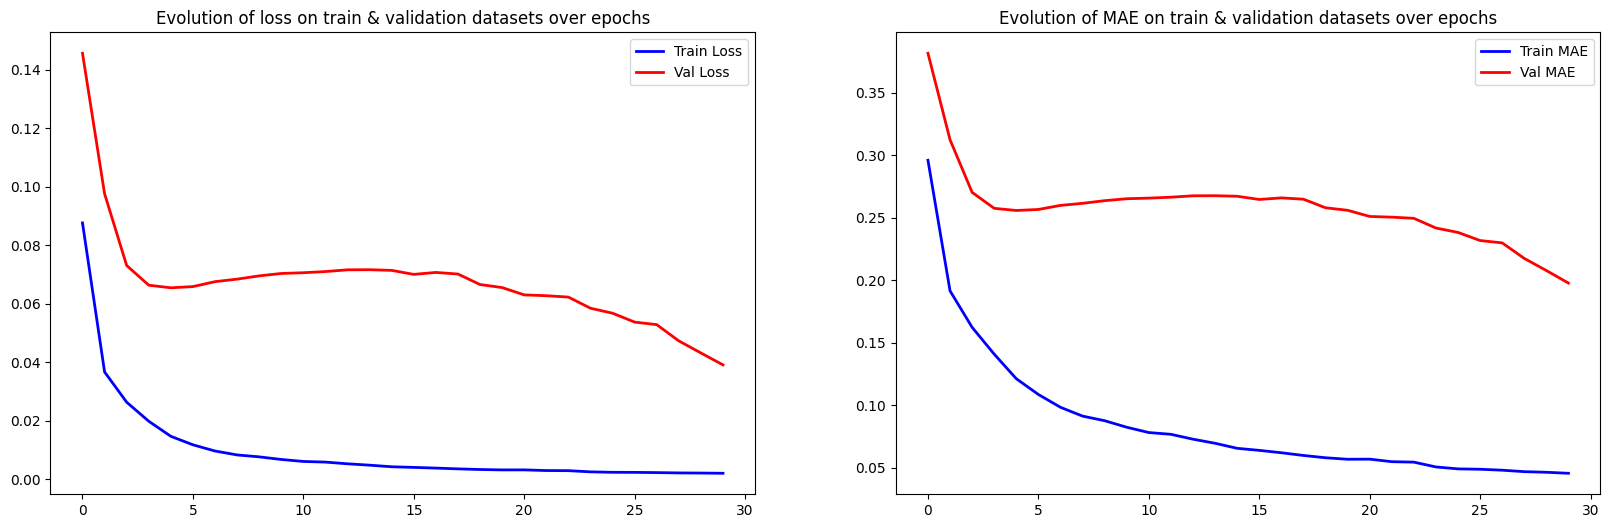

In [16]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['root_mean_squared_error']
epoch_val_mae = history.history['val_root_mean_squared_error']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [20]:
# predict/clean test images
Y_test = model.predict(X_test)



3/3 [==============================] - 1s 448ms/step


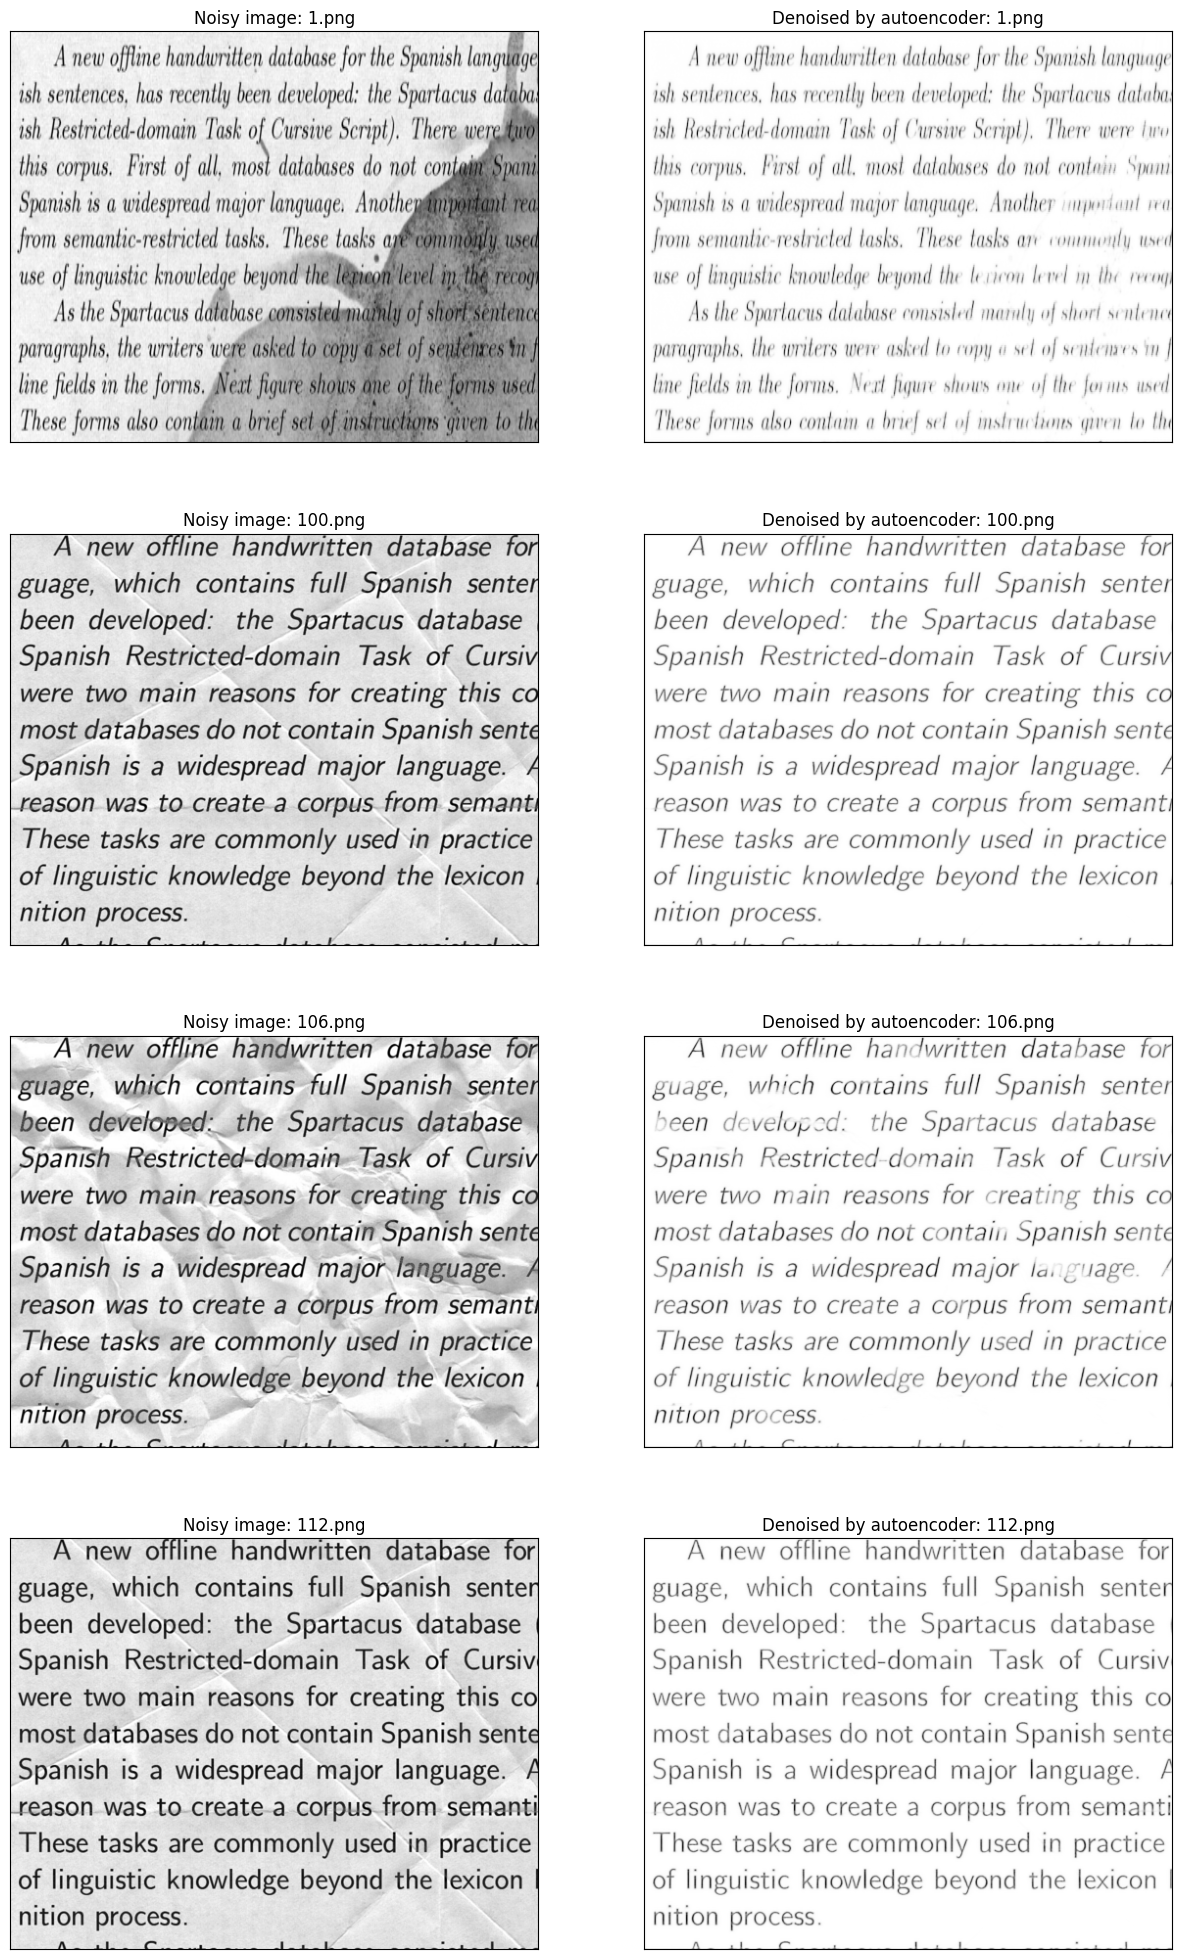

In [21]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_names[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_names[i]))

plt.show()